INSTALL THE FOLLOWING PYTHON PACKAGES FIRST BEFORE RUNNING THE PROGRAM

1) Numpy
2) NNFS - for the Spiral dataset
3) scikit-learn - for the iris dataset

In [62]:
# Library imports
import numpy as np

Create classes for modularity

In [63]:
class Layer_Dense:

    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))


    # Forward pass
    def forward(self, inputs):
        # Remember the input values
        self.inputs = inputs
        # Calculate the output values from inputs, weight and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass/Backpropagation
    def backward(self, dvalues):
        # Gradients on parameters:
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


In [64]:
# Activation Functions
# Included here are the functions for both the forward and backward pass

# Linear
class ActivationLinear:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()

# Sigmoid
class ActivationSigmoid:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    def backward(self, dvalues):
        self.dinputs = dvalues * (self.output * (1 - self.output))

# TanH
class ActivationTanH:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.tanh(inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues * (1 - self.output ** 2)

# ReLU
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        # Remember the input values
        self.inputs = inputs
        # Calculate the output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Make a copy of the original values first
        self.dinputs = dvalues.copy()
    
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

# Softmax
class Activation_Softmax:
    # Forward pass
    def forward(self, inputs):
        # Remember the inputs values
        self.inputs = inputs

        # Get the unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))

        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):

            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calculate the sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

In [65]:
# Loss functions

class Loss:
    # Calculate the data and regularization losses
    # Given the model output and grou truth/target values
    def calculate(self, output, y):
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        # Calculate the mean loss
        data_loss = np.mean(sample_losses)
        # Return the mean loss
        return data_loss

# MSE
class Loss_MSE:
    def forward(self, y_pred, y_true):
        # Calculate Mean Squared Error
        return np.mean((y_true - y_pred) ** 2, axis=-1)

    def backward(self, y_pred, y_true):
        # Gradient of MSE loss
        samples = y_true.shape[0]
        outputs = y_true.shape[1]
        self.dinputs = -2 * (y_true - y_pred) / outputs
        # Normalize gradients over samples
        self.dinputs = self.dinputs / samples

# Binary Cross-Entropy
class Loss_BinaryCrossEntropy:
    def forward(self, y_pred, y_true):
        # Clip predictions
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        # Calculate Binary Cross Entropy
        return -(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))

    def backward(self, y_pred, y_true):
        # Gradient of BCE loss
        samples = y_true.shape[0]
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        self.dinputs = - (y_true / y_pred_clipped - (1 - y_true) / (1 - y_pred_clipped))
        # Normalize gradients over samples
        self.dinputs = self.dinputs / samples

# Categorical Cross-Entropy
class Loss_CategoricalCrossEntropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        samples = y_pred.shape[0]
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])

        # Convert labels to one-hot if sparse
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Prevent division by 0
        dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)

        # Calculate the gradient
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples


<!-- Star -->

In [66]:
class Optimizer_SGD:
    def __init__(self, learning_rate=1.0, decay=0, momentum=0., adaptive=False, epsilon=1e-7):
        """
        SGD Optimizer supporting:
        - learning_rate: base learning rate
        - decay: learning rate decay (default=0, disabled)
        - momentum: momentum factor (default=0, disabled)
        - adaptive: enable Adagrad adaptive learning (default=False)
        - epsilon: small constant for numerical stability in Adagrad
        """
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
        self.adaptive = adaptive
        self.epsilon = epsilon

    def pre_update_params(self):
        """Adjust learning rate using decay before parameter update."""
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        """Update layer parameters (weights and biases)."""
        # ---------- Momentum ----------
        if self.momentum:
            # Initialize momentums if they don't exist yet
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            # Compute updates with momentum
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            bias_updates   = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            
            # Store momentums for next iteration
            layer.weight_momentums = weight_updates
            layer.bias_momentums   = bias_updates
        else:
            # Vanilla SGD (no momentum)
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates   = -self.current_learning_rate * layer.dbiases

        # ---------- Adaptive Gradient (Adagrad) ----------
        if self.adaptive:
            # Initialize caches if they don't exist yet
            if not hasattr(layer, 'weight_cache'):
                layer.weight_cache = np.zeros_like(layer.weights)
                layer.bias_cache = np.zeros_like(layer.biases)

            # Accumulate squared gradients
            layer.weight_cache += layer.dweights ** 2
            layer.bias_cache += layer.dbiases ** 2

            # Apply Adagrad update rule
            weight_updates = -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
            bias_updates   = -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)

        # Apply the updates
        layer.weights += weight_updates
        layer.biases  += bias_updates

    def post_update_params(self):
        """Increase iteration counter after updates."""
        self.iterations += 1

Use most of the classes to create a functioning neural network, capable of performing a forward and backward pass

We can use a sample dataset from the Spiral module.  

We can also use the IRIS dataset.

X shape: (300, 2)
y shape: (300,)


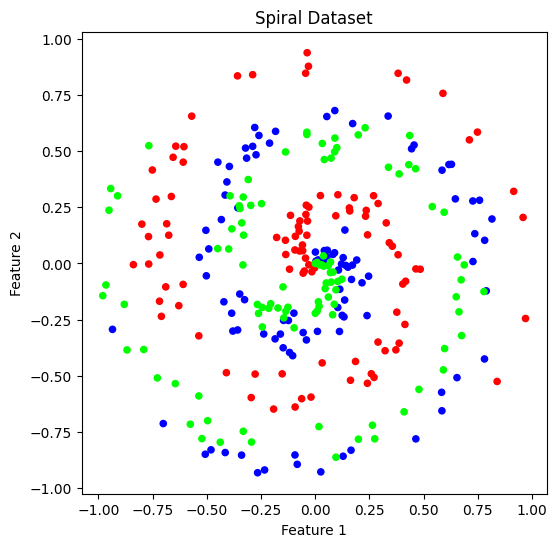

In [67]:
# Spiral Data
import nnfs
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt

# Initialize nnfs (sets random seed, dtype)
nnfs.init()

# Create the dataset
X, y = spiral_data(samples=100, classes=3)

# Print shapes to confirm
print("X shape:", X.shape)
print("y shape:", y.shape)

# Plot the data
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="brg", s=20)
plt.title("Spiral Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


In [68]:
# Iris Dataset
from sklearn.datasets import load_iris
import numpy as np

# Load the dataset
iris = load_iris()

# Features and labels
X = iris.data        # (150, 4)
y = iris.target      # (150,)

# Print basic info
print("X shape:", X.shape)
print("y shape:", y.shape)
print("First 5 samples:\n", X[:5])
print("First 5 labels:", y[:5])

# Optional: Shuffle and normalize
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

# Shuffle data
X, y = shuffle(X, y, random_state=42)

# Normalize features (zero mean, unit variance)
scaler = StandardScaler()
X = scaler.fit_transform(X)


X shape: (150, 4)
y shape: (150,)
First 5 samples:
 [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
First 5 labels: [0 0 0 0 0]


In [69]:
# Neural Network initialization

# For Spiral data (2 input features, 3 output classes)
dense1 = Layer_Dense(2, 3)
activation1 = Activation_ReLU()

# Second Dense layer
dense2 = Layer_Dense(3, 3)
activation2 = Activation_Softmax()

# Loss function
loss_function = Loss_CategoricalCrossEntropy()

# Optimizer (with optional momentum & decay)
optimizer = Optimizer_SGD(
    learning_rate=1.0,
    decay=1e-3,
    momentum=0.9
)

print("Neural network initialized (Spiral data configuration)")

Neural network initialized (Spiral data configuration)


PERFORM ONLY 1 PASS

In [70]:
dense1 = Layer_Dense(4, 3)   # 4 input features → 3 neurons
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3, 3)   # 3 neurons → 3 output classes
activation2 = Activation_Softmax()


In [71]:
dense1.forward(X)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
loss_function.forward(activation2.output, y)

loss_function.backward(activation2.output, y)
activation2.backward(loss_function.dinputs)
dense2.backward(activation2.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)

optimizer.update_params(dense1)
optimizer.update_params(dense2)


In [72]:
print(dense1.dweights.shape, dense1.dbiases.shape)
print(dense2.dweights.shape, dense2.dbiases.shape)

optimizer.update_params(dense1)
optimizer.update_params(dense2)


(4, 3) (1, 3)
(3, 3) (1, 3)


In [73]:
epochs = 1000

for epoch in range(epochs):
    # Forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    # Compute loss
    loss = np.mean(loss_function.forward(activation2.output, y))    
    predictions = np.argmax(activation2.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)

    # Backward pass
    loss_function.backward(activation2.output, y)
    activation2.backward(loss_function.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)

    if not epoch % 100:
        print(f'Epoch: {epoch}, Loss: {loss:.3f}, Accuracy: {accuracy:.3f}')


Epoch: 0, Loss: 1.098, Accuracy: 0.633
Epoch: 100, Loss: 0.088, Accuracy: 0.967
Epoch: 200, Loss: 0.040, Accuracy: 0.987
Epoch: 300, Loss: 0.040, Accuracy: 0.987
Epoch: 400, Loss: 0.040, Accuracy: 0.987
Epoch: 500, Loss: 0.040, Accuracy: 0.987
Epoch: 600, Loss: 0.040, Accuracy: 0.987
Epoch: 700, Loss: 0.040, Accuracy: 0.987
Epoch: 800, Loss: 0.040, Accuracy: 0.987
Epoch: 900, Loss: 0.040, Accuracy: 0.987
